## Collected Mututal fund data using screeners

https://finance.yahoo.com/screener/unsaved/b8a2572f-78a8-407b-b317-827a6dde3238?count=100&offset=300



In [2]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

In [54]:
MF_data = pd.read_csv('Yahoo_tickers_MF.txt',delimiter='\t')
# Testing on first 1000 MFs
MF_data = MF_data[:100]


In [56]:
MF_data.columns

Index(['Symbol', 'Name', 'Change', '% Change', 'Price (Intraday)',
       '50 Day Average', '200 Day Average', '3-Mo Return', 'YTD Return',
       '52 Week Range'],
      dtype='object')

## Plot historical data

In [58]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np 
from ipywidgets import interact
from ipywidgets import interact

output_mf = widgets.Output()


MF_select = widgets.Dropdown(
    options=MF_data['Name'].tolist(),
    value=MF_data['Name'].iloc[0],
    description='Mutual Fund',
    disabled=False,
)
# Define a function to handle the change event
def plot_dropdown(Name):
    
    output_mf.clear_output()
    with output_mf:
        
        fig,ax = plt.subplots(1,1,figsize=(6,6))
        selected_option = Name
        ticker = yf.Ticker(MF_data.loc[MF_data['Name'] == selected_option, 'Symbol'].iloc[0])
        mf_df = ticker.history(period="5y")
        title=f"{selected_option} Stock Price"
        threshold = 20

        if len(title) > threshold:
            title = title[:threshold] + "\n" + title[threshold:]

        mf_df['Close'].plot(ax=ax)
        ax.set_title(title)
        ax.set_ylabel('NAV')
        plt.show()

# Register the change event handler
widgets.interact(plot_dropdown, Name=MF_select)

# display(MF_select)
display(output_mf)

interactive(children=(Dropdown(description='Mutual Fund', options=('HDFC Equity Savings Fund -Direct Plan Divi…

Output()

- Taking the top 100 best performing MFs based on the 3 yr returns



In [59]:
import multiprocessing

def three_yr_return(name):
    ticker = yf.Ticker(MF_data.loc[MF_data['Name'] == name, 'Symbol'].iloc[0])
    mf_df = ticker.history(period="3y")
    mf_df["Daily_Return"] = mf_df["Close"].pct_change()
    # Calculate cumulative return over the 3-year period
    tyr = np.prod(1 + mf_df["Daily_Return"][-252 * 3:]) - 1 
    return (tyr/3)*100

if __name__=="__main__":
    
    with multiprocessing.Pool(8) as pool:
        ret3 = pool.map(three_yr_return, MF_data['Name'].tolist())
    
        MF_data['3yr'] =  ret3

    

In [60]:
MF_data.reset_index().to_feather('MF_data_tmp.dat')

In [61]:
MF_data.sort_values(by='3yr',ascending=False,inplace=True)

In [62]:
# Select top 100 MFs
MF_data['3yr'].head

<bound method NDFrame.head of 55    32.586797
57    31.409122
38    29.860464
9     29.458947
39    28.141192
        ...    
78    -0.050481
54    -0.055440
49    -0.055774
40    -0.076771
43    -0.077136
Name: 3yr, Length: 100, dtype: float64>

## Sharpe ratio

In [64]:
import yfinance as yf
import pandas as pd
import numpy as np
import tqdm 

def get_sharpe_ratio(ticker_symbol, risk_free_rate):
    ticker = yf.Ticker(ticker_symbol)
    mf_df = ticker.history(period="3y")
    daily_returns =  mf_df["Close"].pct_change()
    # Calculate average daily return and standard deviation of daily returns
    avg_daily_return = daily_returns.mean()
    std_dev_daily_return = daily_returns.std()

    # Annualize average daily return and standard deviation
    annual_return = avg_daily_return * 252
    annual_volatility = std_dev_daily_return * np.sqrt(252)

    # Calculate the Sharpe ratio using the risk-free rate
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility

    return sharpe_ratio


sr = []
for mf_symb in tqdm.tqdm(MF_data['Symbol'].tolist()):
    
    #print(ticker_symbol)
    # Risk-free rate 
    risk_free_rate = 0.04

    # Calculate the Sharpe ratio
    sr.append(get_sharpe_ratio(mf_symb, risk_free_rate))
    # print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

MF_data['Sharpe'] = np.array(sr)


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


In [65]:
MF_data.reset_index().to_feather('MF_data_tmp.dat')

<Axes: ylabel='Frequency'>

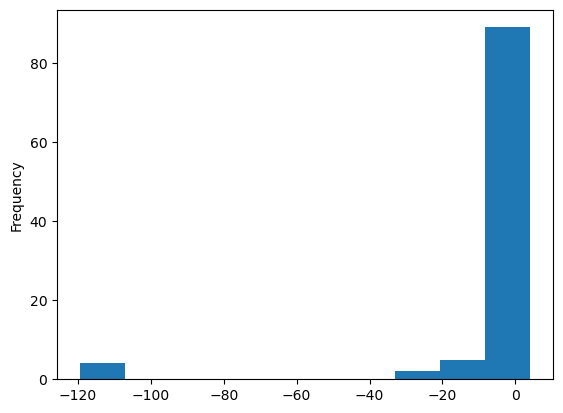

In [66]:

MF_data['Sharpe'].plot(kind='hist')

In [67]:
MF_data['Sharpe'].describe()

count    100.000000
mean      -6.418477
std       23.517518
min     -119.543621
25%       -2.834141
50%       -0.666857
75%        1.211979
max        4.134221
Name: Sharpe, dtype: float64

## CAGR 

In [71]:
def calculate_cagr(ticker_symbol):
    ticker = yf.Ticker(ticker_symbol)
    mf_df = ticker.history(period="1y")
    initial_value = mf_df["Close"].iloc[0]
    final_value = mf_df["Close"].iloc[-1]
    years = len(mf_df) / 252  # Assuming 252 trading days per year
    cagr = ((final_value / initial_value) ** (1 / years)) - 1
    return cagr * 100  # Convert to percentage

cagr = []
for mf_symb in tqdm.tqdm(MF_data['Symbol'].tolist()):

    # Calculate the Sharpe ratio
    cagr.append(calculate_cagr(mf_symb))
    # print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

MF_data['CAGR'] = np.array(cagr)

MF_data.reset_index().to_feather('MF_data_tmp.dat')

100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


<Axes: ylabel='Frequency'>

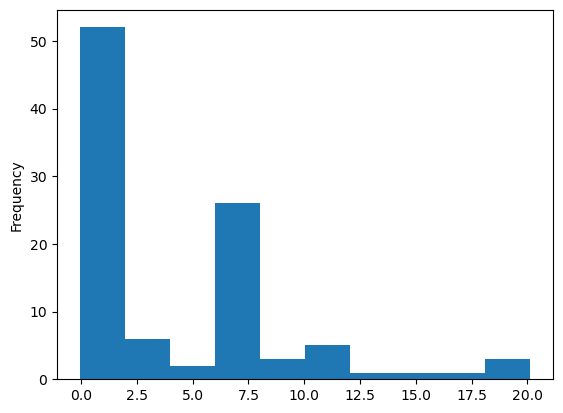

In [72]:
MF_data['CAGR'].plot(kind='hist')

In [73]:
MF_data['CAGR'].describe()

count    100.000000
mean       4.031817
std        4.909278
min       -0.071305
25%        0.048052
50%        0.938434
75%        6.888505
max       20.139007
Name: CAGR, dtype: float64

## Sortino ratio

In [82]:
def calculate_sortino_ratio(ticker_symbol, risk_free_rate):
    
    ticker = yf.Ticker(ticker_symbol)
    mf_df = ticker.history(period="3y")
    returns =  mf_df["Close"].pct_change().dropna()
    downside_returns = returns[returns < 0]
    downside_deviation = np.std(downside_returns)
    
    expected_return = returns.mean()
    excess_return = expected_return - risk_free_rate
    
    sortino_ratio = excess_return / downside_deviation
    return sortino_ratio

sr = []
for mf_symb in tqdm.tqdm(MF_data['Symbol'].tolist()):
    # risk-free rate
    risk_free_rate = 0.04
    sr.append(calculate_sortino_ratio(mf_symb, risk_free_rate))

MF_data['Sortino'] = np.array(sr)
MF_data.reset_index().to_feather('MF_data_tmp.dat')

100%|██████████| 100/100 [00:45<00:00,  2.20it/s]


<Axes: ylabel='Frequency'>

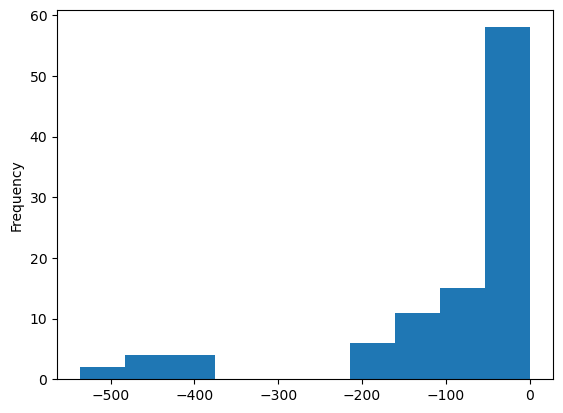

In [83]:
MF_data['Sortino'].plot(kind='hist')

In [84]:
MF_data['Sortino'].describe()

count    100.000000
mean     -89.600527
std      131.814486
min     -536.923074
25%     -107.702893
50%      -23.257374
75%       -9.467334
max        1.001575
Name: Sortino, dtype: float64

## Alpha and Beta of MFs

In [103]:

import statsmodels.api as sm

def get_alpha_beta(ticker_symbol,benchmark_ticker):
    ticker = yf.Ticker(ticker_symbol)
    mf_df = ticker.history(period="1y")['Close'].tz_localize(None)
    # Download historical data using yfinance
    benchmark_data = yf.download(benchmark_ticker, period="1y",progress=False)["Close"].tz_localize(None)

    # Combine dataframes and drop missing values
    combined_data = pd.concat([mf_df, benchmark_data], axis=1, keys=[ticker_symbol, benchmark_ticker])
    combined_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_data.dropna(inplace=True)

    # Calculate daily returns
    fund_returns = combined_data[ticker_symbol].pct_change()[1:]
    benchmark_returns = combined_data[benchmark_ticker].pct_change()[1:]

    # print(benchmark_returns.describe())

    # Calculate beta using linear regression
    X = sm.add_constant(benchmark_returns)
    model = sm.OLS(fund_returns, X).fit()
    beta = model.params[benchmark_ticker]

    expected_return = risk_free_rate + beta * (benchmark_returns.mean() - risk_free_rate)

    # Calculate alpha
    alpha = (fund_returns.mean() - expected_return) * 252  # Annualize alpha
    
    return alpha, beta

# Calculate the expected return of the fund based on CAPM
risk_free_rate = 0.01  # Replace with the appropriate risk-free rate

MF_data['Alpha'] = np.nan
MF_data['Beta'] = np.nan
benchmark_ticker = '^BSESN'
for mf_symb in tqdm.tqdm(MF_data['Symbol'].tolist()):
    alpha, beta = get_alpha_beta(mf_symb,benchmark_ticker)
    MF_data.loc[MF_data['Symbol'] == mf_symb, 'Alpha'] = alpha
    MF_data.loc[MF_data['Symbol'] == mf_symb, 'Beta'] = beta



100%|██████████| 100/100 [01:38<00:00,  1.02it/s]


In [104]:
MF_data.reset_index().to_feather('MF_data_tmp.dat')

<Axes: ylabel='Frequency'>

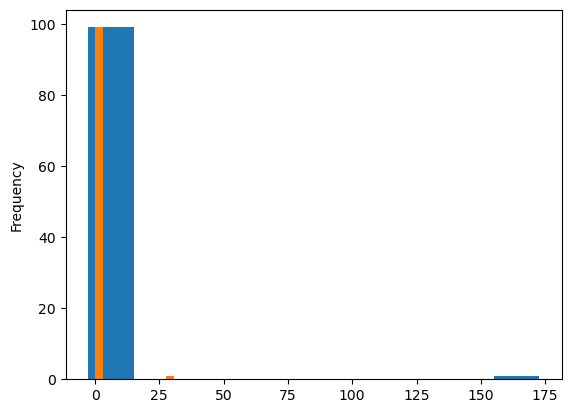

In [108]:
MF_data['Alpha'].plot(kind='hist');MF_data['Beta'].plot(kind='hist')

In [111]:
MF_data['Alpha'].describe()


count    100.000000
mean      -0.366275
std       17.506514
min       -2.573493
25%       -2.526142
50%       -2.466049
75%       -2.400610
max      172.770321
Name: Alpha, dtype: float64

In [112]:
MF_data['Beta'].describe()


count    100.000000
mean       0.456606
std        3.071178
min       -0.023504
25%       -0.003566
50%        0.003576
75%        0.021306
max       30.702013
Name: Beta, dtype: float64